In [1]:
import math
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

#
from utils_feature_engineering import *
from sklearn.impute import SimpleImputer

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

C:\Users\Hải Nam\AppData\Local\Temp\ipykernel_12608\3382209636.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Load data

In [2]:
# load train/test data
path = r'D:\NEU\Năm 3\DATA PREP\PROJECT_DATAPREP\GITHUB REPO\dataset\dseb63_final_project_DP_dataset\\'

# train
application_train = pd.read_csv(path + 'dseb63_' + 'application_train.csv')
application_train.drop(columns='Unnamed: 0', inplace=True)
# test
application_test = pd.read_csv(path + 'dseb63_' + 'application_test.csv')
application_test.drop(columns='Unnamed: 0', inplace=True)

In [3]:
# filter by tvt code
application_tvt_extend = pd.read_pickle("application_tvt_extend.pkl", compression="bz2")
application_train_filtered = (application_tvt_extend.query("tvt_code == 'train'")
                              .merge(application_train[["SK_ID_CURR"]], on="SK_ID_CURR")
                              .drop(columns=["tvt_code"]))
application_train_filtered.head()

,SK_ID_CURR,TARGET
0,278621,0
1,139008,0
2,138348,0
3,53466,0
4,27272,0


In [4]:
# load previous application table
previous_app = pd.read_csv(path + 'dseb63_' + 'previous_application.csv')
previous_app.head()

,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,SK_ID_CURR
0,2030495,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0000,0.1828,0.8673,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,293189
1,1696966,Consumer loans,68258.655,1800000.0,1754721.0,180000.0,1800000.0,SATURDAY,18,Y,1,0.1013,NaN,NaN,XAP,Refused,-472,Cash through the bank,SCO,NaN,Repeater,Clothing and Accessories,POS,XNA,Regional / Local,55,Furniture,36.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN,293189
2,2154916,Consumer loans,12417.390,108400.5,119848.5,0.0,108400.5,SUNDAY,14,Y,1,0.0000,NaN,NaN,XAP,Approved,-548,Cash through the bank,XAP,NaN,New,Furniture,POS,XNA,Stone,196,Furniture,12.0,middle,POS industry with interest,365243.0,-512.0,-182.0,-392.0,-387.0,0.0,293189
3,2802425,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,91587
4,1536272,Cash loans,21709.125,450000.0,512370.0,NaN,450000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-515,XNA,XAP,NaN,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),6,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,-485.0,565.0,-155.0,-147.0,1.0,91587


# Preprocessing data

## NAME_CONTRACT_TYPE

In [5]:
previous_app['NAME_CONTRACT_TYPE'].value_counts(dropna=False)

Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                313   
Name: NAME_CONTRACT_TYPE, dtype: int64

In [6]:
# số lượng XNA khá nhỏ, chỉ có 313 records do đó ta có thể Replace thành Cash loans mà không ảnh hưởng nhiều đến mẫu
previous_app.loc[previous_app['NAME_CONTRACT_TYPE'] == "XNA","NAME_CONTRACT_TYPE"] = 'Cash loans'
previous_app['NAME_CONTRACT_TYPE'].value_counts(dropna=False)

Cash loans         627077
Consumer loans     625256
Revolving loans    161368
Name: NAME_CONTRACT_TYPE, dtype: int64

## AMT_ANNUITY

AMT_ANNUITY: Số tiền phải trả hàng năm

In [7]:
previous_app[previous_app['AMT_ANNUITY'].isna()]['NAME_CONTRACT_STATUS'].value_counts(dropna = False)

Canceled        250681
Refused         34542 
Unused offer    21988 
Approved        7     
Name: NAME_CONTRACT_STATUS, dtype: int64

In [8]:
# AMT_ANNUITY bị null khi tình trạng của HĐ là hủy.
# chỉ một số ít AMT_ANNUITY là null nhưng tình trạng của HĐ là approved.
# Fill giá trị này là 0
previous_app.loc[previous_app["AMT_ANNUITY"].isna(), "AMT_ANNUITY"] = 0
previous_app["AMT_ANNUITY"].isna().sum()

0

## AMT_DOWN_PAYMENT

KH phải trả số tiền ban đầu là bao nhiêu (tiền trả trước, tiền đặt cọc)

In [9]:
previous_app['AMT_DOWN_PAYMENT'].isna().mean()

0.5301969794178543

> AMT_DOWN_PAYMENT chứa 53% null data

In [10]:
# Mặc định KH không trả giá trị ban đầu mà vay toàn bộ. Fill 0 cho các giá trị null này
previous_app.loc[previous_app["AMT_DOWN_PAYMENT"].isna(),"AMT_DOWN_PAYMENT"] = 0
previous_app["AMT_DOWN_PAYMENT"].isna().sum()

0

## AMT_GOODS_PRICE

Số tiền của sản phẩm mà khách hàng muốn vay trả góp


In [11]:
previous_app["AMT_GOODS_PRICE"].isna().mean()

0.2260202121947993

> AMT_GOODS_PRICE có 23% data null cần được fill

In [12]:
# Có rất nhiều giá trị 0 tại cột AMT_CREDIT khi AMT_GOODS_PRICE là null
series_check_amt_credit = previous_app[previous_app['AMT_GOODS_PRICE'].isna()]['AMT_CREDIT']

amt_credit_0 = series_check_amt_credit[series_check_amt_credit == 0]
amt_credit_0.count() / series_check_amt_credit.shape[0]

0.8587371880134574

In [13]:
# giải ngân là 0, tình trạng của HĐ là approved
previous_app.loc[amt_credit_0]['NAME_CONTRACT_STATUS'].value_counts(dropna=False)

Approved    274388
Name: NAME_CONTRACT_STATUS, dtype: int64

In [14]:
# giải ngân là 0, mục đích vay là XAP
previous_app.loc[amt_credit_0]['NAME_CASH_LOAN_PURPOSE'].value_counts(dropna=False)

XAP    274388
Name: NAME_CASH_LOAN_PURPOSE, dtype: int64

In [15]:
# Fill 0 cho các giá trị AMT_GOODS_PRICE à 0
previous_app.loc[previous_app["AMT_GOODS_PRICE"].isna(), "AMT_GOODS_PRICE"] = 0
previous_app["AMT_GOODS_PRICE"].isna().sum()

0

## RATE_DOWN_PAYMENT, RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED

    RATE_DOWN_PAYMENT : tỉ lệ tiền đặt cọc (normalized)
    RATE_INTEREST_PRIMARY : tỉ lệ lãi suất chính (normalized)
    RATE_INTEREST_PRIVILEGED: tỉ lệ lãi suất ưu tiên (normalized)

In [16]:
previous_app["RATE_DOWN_PAYMENT"].isna().mean()

0.5301969794178543

In [17]:
previous_app["RATE_DOWN_PAYMENT"].value_counts(dropna = False)

NaN       749540
0.0000    313975
0.1089    31741 
0.2178    5493  
0.3267    926   
         ...    
0.1079    1     
0.0506    1     
0.0983    1     
0.2302    1     
0.1089    1     
Name: RATE_DOWN_PAYMENT, Length: 185079, dtype: int64

In [18]:
previous_app["RATE_INTEREST_PRIMARY"].isna().mean()

0.9966110231229942

In [19]:
previous_app["RATE_INTEREST_PRIMARY"].value_counts(dropna=False)

NaN       1408910
0.1891    984    
0.1424    792    
0.1607    687    
0.1933    553    
0.1969    466    
0.1607    172    
0.1891    161    
0.1760    146    
0.1828    127    
0.1969    115    
0.1933    58     
0.1797    52     
0.1425    51     
0.6962    41     
0.0591    40     
0.1421    25     
0.1918    17     
0.1828    16     
0.1933    15     
0.1797    15     
0.1278    14     
0.1892    14     
0.6963    11     
0.6963    9      
0.7008    8      
0.1417    7      
0.6360    6      
0.1424    6      
0.6546    6      
0.6545    6      
0.2076    6      
0.2076    5      
0.6962    5      
0.1760    4      
0.2076    4      
0.1969    4      
0.6360    4      
0.6359    4      
0.2076    4      
0.2076    3      
0.1891    3      
0.2076    3      
0.1715    3      
0.1760    3      
0.6962    3      
0.6957    3      
0.1836    3      
0.1747    3      
0.1917    2      
0.6545    2      
0.6955    2      
0.1607    2      
0.1420    2      
0.6901    2      
0.1797    

In [20]:
previous_app["RATE_INTEREST_PRIVILEGED"].isna().mean()

0.9966110231229942

In [21]:
previous_app["RATE_INTEREST_PRIVILEGED"].value_counts(dropna=False)

NaN       1408910
0.8351    1328   
0.7156    876    
0.6379    870    
0.8673    735    
0.8525    699    
0.5687    110    
0.4244    44     
0.5137    40     
0.8325    34     
0.8451    19     
0.6374    6      
0.7807    6      
0.7252    5      
0.6448    5      
0.7907    4      
0.8066    2      
0.4366    2      
0.8208    1      
1.0000    1      
0.5481    1      
0.3732    1      
0.5021    1      
0.4841    1      
Name: RATE_INTEREST_PRIVILEGED, dtype: int64

In [22]:
# Fill median với giả định ngân hàng đa phần cho vay với tỉ lệ này 
# nên hiếm khi điền thông tin cho trường này
imputer = SimpleImputer(strategy='median')
previous_app['RATE_DOWN_PAYMENT'] = imputer.fit_transform(previous_app[['RATE_DOWN_PAYMENT']])
previous_app['RATE_INTEREST_PRIMARY'] = imputer.fit_transform(previous_app[['RATE_INTEREST_PRIMARY']])
previous_app['RATE_INTEREST_PRIVILEGED'] = imputer.fit_transform(previous_app[['RATE_INTEREST_PRIVILEGED']])

## CNT_PAYMENT

 Kì hạn của khoản vay

In [23]:
# CNT_PAYMENT chứa 22% null
previous_app["CNT_PAYMENT"].isna().mean()

0.21731115702683948

In [24]:
# Có rất nhiều giá trị 0 tại cột AMT_CREDIT khi CNT_PAYMENT là Null
series_check = previous_app[previous_app["CNT_PAYMENT"].isna()]["AMT_CREDIT"]
series_check[series_check == 0.0].count() * 1.0 / series_check.shape[0]

0.896283685911729

In [25]:
previous_app.loc[series_check[series_check == 0.0].index]["NAME_CONTRACT_STATUS"].value_counts(dropna=False)

Canceled        250474
Refused         24446 
Unused offer    430   
Name: NAME_CONTRACT_STATUS, dtype: int64

In [26]:
previous_app.loc[series_check[series_check >0.0].index]["NAME_CONTRACT_STATUS"].value_counts()

Unused offer    21558
Refused         10095
Canceled        207  
Approved        3    
Name: NAME_CONTRACT_STATUS, dtype: int64

In [27]:
list_day_cols = [cname for cname in previous_app.columns if "DAYS" in cname]
list_day_cols

['DAYS_DECISION',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION']

In [28]:
# Những rows có CNT_PAYMENT là null thì các trường DAYS* đều là null.
# Nguyên nhân có thể do KH đã trả trước.
previous_app.loc[series_check.index][list_day_cols].describe()

,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
count,307213.0000,0.0,0.0,0.0,0.0,0.0
mean,-302.4033,NaN,NaN,NaN,NaN,NaN
std,326.4981,NaN,NaN,NaN,NaN,NaN
min,-2516.0000,NaN,NaN,NaN,NaN,NaN
25%,-336.0000,NaN,NaN,NaN,NaN,NaN
50%,-236.0000,NaN,NaN,NaN,NaN,NaN
75%,-143.0000,NaN,NaN,NaN,NaN,NaN
max,-2.0000,NaN,NaN,NaN,NaN,NaN


In [29]:
# Fill 0 cho các trường hợp này
previous_app.loc[previous_app["CNT_PAYMENT"].isna(), "CNT_PAYMENT"] = 0
previous_app["CNT_PAYMENT"].isna().sum()

0

## DAYS_FIRST_DRAWING:
 
 Ngày giải ngân đầu tiên

In [30]:
previous_app["DAYS_FIRST_DRAWING"].isna().mean()

0.396905710613489

In [31]:
# DAYS_FIRST_DRAWING bị null mà vẫn được approved ????
# có thể KH trả toàn bộ tiền, thay đổi ý kiến trước khi nhận được tiền vay
previous_app[previous_app["DAYS_FIRST_DRAWING"].isna()]["NAME_CONTRACT_STATUS"].value_counts(dropna=False)

Canceled        259441
Refused         245390
Approved        33504 
Unused offer    22771 
Name: NAME_CONTRACT_STATUS, dtype: int64

In [32]:
# tạo feature xác định có phải là prepaid user hay không
previous_app["is_PREPAID_USER"] = 0
previous_app.loc[previous_app["DAYS_FIRST_DRAWING"].isna(), "is_PREPAID_USER"] = 1
previous_app["is_PREPAID_USER"].value_counts()

0    852595
1    561106
Name: is_PREPAID_USER, dtype: int64

## Handling DAYS_* == 365243

Các giá trị 365243 ngày (~ 1.000 năm) thể hiện giá trị vô hạn, tương đương null value. Do đó, fill toàn bộ giá trị này thành null và đánh dấu điểm dị biệt này

In [33]:
def handling_days(df_input, cname):
    # Create an anomalous flag column
    df_input["{}_ANOM".format(cname)] = df_input[cname] == 365243

    # Replace the anomalous values with nan
    df_input[cname] = df_input[cname].replace({365243: np.nan})

    # Calculate years
    df_input["{}_TO_YEARS".format(cname)] = df_input[cname] / -365
    df_input.drop(columns=[cname], inplace=True)

    return df_input

print('Percent of anomolies value in each column :\n')
for cname in list_day_cols:
    print("{}: {}".format(cname, (previous_app[cname] == 365243).mean()))
    previous_app = handling_days(previous_app, cname)

Percent of anomolies value in each column :

DAYS_DECISION: 0.0
DAYS_FIRST_DRAWING: 0.5652496532152131
DAYS_FIRST_DUE: 0.02402346748003998
DAYS_LAST_DUE_1ST_VERSION: 0.05595171822047236
DAYS_LAST_DUE: 0.12788559957162088
DAYS_TERMINATION: 0.1372284521267227


## Ordinal encoding

`NAME_CASH_LOAN_PURPOSE, NAME_CONTRACT_STATUS, NAME_PAYMENT_TYPE, CODE_REJECT_REASON, NAME_CLIENT_TYPE, NAME_GOODS_CATEGORY, NAME_PORTFOLIO, CHANNEL_TYPE, NAME_SELLER_INDUSTRY, NAME_YIELD_GROUP`

In [34]:
def ordinal_encoding(df_input, cname):
    # ranking by count frequency
    series_ranking = previous_app[cname].value_counts()

    # generate mapping to ordinal
    categorical_map = dict(zip(series_ranking.index, range(series_ranking.shape[0])))

    # transform values
    previous_app["{}_ordinal".format(cname)] = previous_app[cname].apply(lambda x: categorical_map[x])
    df_input["{}_ordinal".format(cname)] = df_input[cname].apply(lambda x: categorical_map[x])

    return df_input

In [35]:
list_to_ordinal = [
    "NAME_CASH_LOAN_PURPOSE",
    "NAME_CONTRACT_STATUS",
    "NAME_PAYMENT_TYPE",
    "CODE_REJECT_REASON",
    "NAME_CLIENT_TYPE",
    "NAME_GOODS_CATEGORY",
    "NAME_PORTFOLIO",
    "CHANNEL_TYPE",
    "NAME_SELLER_INDUSTRY",
    "NAME_YIELD_GROUP"
]

for cname in list_to_ordinal:
    print("Encoding {}...".format(cname))
    previous_app = ordinal_encoding(previous_app, cname)

# drop columns
previous_app.drop(columns=list_to_ordinal, inplace=True)

Encoding NAME_CASH_LOAN_PURPOSE...
Encoding NAME_CONTRACT_STATUS...
Encoding NAME_PAYMENT_TYPE...
Encoding CODE_REJECT_REASON...
Encoding NAME_CLIENT_TYPE...
Encoding NAME_GOODS_CATEGORY...
Encoding NAME_PORTFOLIO...
Encoding CHANNEL_TYPE...
Encoding NAME_SELLER_INDUSTRY...
Encoding NAME_YIELD_GROUP...


## NAME_TYPE_SUITE

Ai đi cùng KH tới vay

In [36]:
previous_app["NAME_TYPE_SUITE"].isna().mean()

0.4913853778132717

In [37]:
previous_app['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      427635
Family             181880
Spouse, partner    57586 
Children           27106 
Other_B            15073 
Other_A            7820  
Group of people    1929  
Name: NAME_TYPE_SUITE, dtype: int64

In [38]:
# Fill na là Unaccompanied
previous_app.loc[previous_app["NAME_TYPE_SUITE"].isna(),"NAME_TYPE_SUITE"] = "Unaccompanied"
previous_app["NAME_TYPE_SUITE"].isna().sum()

0

## Categorical Features

In [39]:
# get list categorical attributes
# ls_cate = df_meta.query("sub_type == 'object'")["name"].tolist()
series_type = previous_app.dtypes
list_categorical = series_type[series_type == "object"].index.tolist()
list_categorical

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_TYPE_SUITE',
 'NAME_PRODUCT_TYPE',
 'PRODUCT_COMBINATION']

In [40]:
# construct categorical mapping
dict_onehot = {}
for cate in list_categorical:
    list_val = previous_app[cate].value_counts().index.tolist()
    dict_onehot[cate] = list_val

In [41]:
dict_onehot

{'NAME_CONTRACT_TYPE': ['Cash loans', 'Consumer loans', 'Revolving loans'],
 'WEEKDAY_APPR_PROCESS_START': ['WEDNESDAY',
  'TUESDAY',
  'MONDAY',
  'FRIDAY',
  'THURSDAY',
  'SATURDAY',
  'SUNDAY'],
 'FLAG_LAST_APPL_PER_CONTRACT': ['Y', 'N'],
 'NAME_TYPE_SUITE': ['Unaccompanied',
  'Family',
  'Spouse, partner',
  'Children',
  'Other_B',
  'Other_A',
  'Group of people'],
 'NAME_PRODUCT_TYPE': ['XNA', 'x-sell', 'walk-in'],
 'PRODUCT_COMBINATION': ['Cash',
  'POS household with interest',
  'POS mobile with interest',
  'Cash X-Sell: middle',
  'Cash X-Sell: low',
  'Card Street',
  'POS industry with interest',
  'POS household without interest',
  'Card X-Sell',
  'Cash Street: high',
  'Cash X-Sell: high',
  'Cash Street: middle',
  'Cash Street: low',
  'POS other with interest',
  'POS mobile without interest',
  'POS industry without interest',
  'POS others without interest']}

### One Hot

In [42]:
def gen_one_hot_feat(df_input, dict_feat, main_key="SK_ID_CURR"):
    df_data = df_input.copy()
    select_features = []

    for cname in dict_feat:
        ls_vals = dict_feat[cname]
        for val in ls_vals:
            try:
                new_name = "{}_{}".format(cname, val.replace(" ", "_")
                                          .replace(":", "_")
                                          .replace("/", "_")
                                          .replace("-", "_"))

                select_features.append(new_name)
                df_data[new_name] = df_data[cname].apply(
                    lambda x: int(x == val))
            except Exception as err:
                print("One hot for {}-{}. Error: {}".format(cname, val, err))

    return df_data[[main_key] + select_features]


def agg_common_data(df_input, ls_func, main_key="SK_ID_CURR"):
    ls_agg_name = [cname for cname in df_input.columns if cname != main_key]

In [43]:
def agg_common_data(df_input, ls_func, main_key="SK_ID_CURR"):
    ls_agg_name = [cname for cname in df_input.columns if cname != main_key]

    # define agg
    dict_agg = {}
    for name in ls_agg_name:
        dict_agg[name] = ls_func
    display(dict_agg)

    # do agg
    df_agg = df_input.groupby(main_key).agg(dict_agg)
    print('-' * 100)
    print("After agg: {}".format(df_agg.shape))
    print('-' * 100)

    # rename columns
    name01 = df_agg.columns.get_level_values(0)
    name02 = df_agg.columns.get_level_values(1)
    rename_cols = ["{}_{}".format(tpl[0], tpl[1]) for tpl in zip(name01, name02)]
    df_agg.columns = rename_cols

    return df_agg

In [44]:
%%time
df_onehot = gen_one_hot_feat(previous_app, dict_onehot, main_key="SK_ID_CURR")
print(df_onehot.shape)

(1413701, 40)
Wall time: 17.6 s


In [45]:
df_onehot.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Consumer_loans,NAME_CONTRACT_TYPE_Revolving_loans,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,FLAG_LAST_APPL_PER_CONTRACT_Y,FLAG_LAST_APPL_PER_CONTRACT_N,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Family,"NAME_TYPE_SUITE_Spouse,_partner",NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Group_of_people,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_x_sell,NAME_PRODUCT_TYPE_walk_in,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_POS_household_with_interest,PRODUCT_COMBINATION_POS_mobile_with_interest,PRODUCT_COMBINATION_Cash_X_Sell__middle,PRODUCT_COMBINATION_Cash_X_Sell__low,PRODUCT_COMBINATION_Card_Street,PRODUCT_COMBINATION_POS_industry_with_interest,PRODUCT_COMBINATION_POS_household_without_interest,PRODUCT_COMBINATION_Card_X_Sell,PRODUCT_COMBINATION_Cash_Street__high,PRODUCT_COMBINATION_Cash_X_Sell__high,PRODUCT_COMBINATION_Cash_Street__middle,PRODUCT_COMBINATION_Cash_Street__low,PRODUCT_COMBINATION_POS_other_with_interest,PRODUCT_COMBINATION_POS_mobile_without_interest,PRODUCT_COMBINATION_POS_industry_without_interest,PRODUCT_COMBINATION_POS_others_without_interest
0,293189,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,293189,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,293189,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,91587,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,91587,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
application_train_filtered = application_train[['SK_ID_CURR','TARGET']]
application_train_filtered

,SK_ID_CURR,TARGET
0,278621,0
1,139008,0
2,138348,0
3,64140,0
4,219374,0
...,...,...
246004,90253,0
246005,9027,0
246006,163598,0
246007,300375,1


In [47]:
%%time
df_agg01 = agg_common_data(df_onehot, ["max", "sum", "mean"], main_key="SK_ID_CURR")
eval_agg01 = feature_evaluate(application_train_filtered, df_agg01)

display(eval_agg01)

{'NAME_CONTRACT_TYPE_Cash_loans': ['max', 'sum', 'mean'],
 'NAME_CONTRACT_TYPE_Consumer_loans': ['max', 'sum', 'mean'],
 'NAME_CONTRACT_TYPE_Revolving_loans': ['max', 'sum', 'mean'],
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY': ['max', 'sum', 'mean'],
 'WEEKDAY_APPR_PROCESS_START_TUESDAY': ['max', 'sum', 'mean'],
 'WEEKDAY_APPR_PROCESS_START_MONDAY': ['max', 'sum', 'mean'],
 'WEEKDAY_APPR_PROCESS_START_FRIDAY': ['max', 'sum', 'mean'],
 'WEEKDAY_APPR_PROCESS_START_THURSDAY': ['max', 'sum', 'mean'],
 'WEEKDAY_APPR_PROCESS_START_SATURDAY': ['max', 'sum', 'mean'],
 'WEEKDAY_APPR_PROCESS_START_SUNDAY': ['max', 'sum', 'mean'],
 'FLAG_LAST_APPL_PER_CONTRACT_Y': ['max', 'sum', 'mean'],
 'FLAG_LAST_APPL_PER_CONTRACT_N': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Unaccompanied': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Family': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Spouse,_partner': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Children': ['max', 'sum', 'mean'],
 'NAME_TYPE_SUITE_Other_B': ['max', '

----------------------------------------------------------------------------------------------------
After agg: (291057, 117)
----------------------------------------------------------------------------------------------------


,name,auc,corr,coverage
64,NAME_PRODUCT_TYPE_walk_in_sum,0.5499,0.0633,1.0
65,NAME_PRODUCT_TYPE_walk_in_mean,0.5498,0.0588,1.0
63,NAME_PRODUCT_TYPE_walk_in_max,0.5466,0.0590,1.0
7,NAME_CONTRACT_TYPE_Revolving_loans_sum,0.5373,0.0459,1.0
8,NAME_CONTRACT_TYPE_Revolving_loans_mean,0.5360,0.0404,1.0
82,PRODUCT_COMBINATION_Card_Street_sum,0.5336,0.0481,1.0
5,NAME_CONTRACT_TYPE_Consumer_loans_mean,0.5330,-0.0321,1.0
83,PRODUCT_COMBINATION_Card_Street_mean,0.5328,0.0419,1.0
6,NAME_CONTRACT_TYPE_Revolving_loans_max,0.5324,0.0371,1.0
81,PRODUCT_COMBINATION_Card_Street_max,0.5311,0.0409,1.0


Wall time: 24.5 s


In [48]:
eval_agg01[eval_agg01['auc'] > 0.501]['name']

64     NAME_PRODUCT_TYPE_walk_in_sum                          
65     NAME_PRODUCT_TYPE_walk_in_mean                         
63     NAME_PRODUCT_TYPE_walk_in_max                          
7      NAME_CONTRACT_TYPE_Revolving_loans_sum                 
8      NAME_CONTRACT_TYPE_Revolving_loans_mean                
82     PRODUCT_COMBINATION_Card_Street_sum                    
5      NAME_CONTRACT_TYPE_Consumer_loans_mean                 
83     PRODUCT_COMBINATION_Card_Street_mean                   
6      NAME_CONTRACT_TYPE_Revolving_loans_max                 
81     PRODUCT_COMBINATION_Card_Street_max                    
80     PRODUCT_COMBINATION_Cash_X_Sell__low_mean              
4      NAME_CONTRACT_TYPE_Consumer_loans_sum                  
78     PRODUCT_COMBINATION_Cash_X_Sell__low_max               
86     PRODUCT_COMBINATION_POS_industry_with_interest_mean    
79     PRODUCT_COMBINATION_Cash_X_Sell__low_sum               
85     PRODUCT_COMBINATION_POS_industry_with_interest_s

In [49]:
selected_feat = sel_feat = eval_agg01[eval_agg01['auc'] > 0.501]['name'].tolist()
df_agg01 = df_agg01[selected_feat]
df_agg01.shape

(291057, 103)

In [50]:
df_agg01.head()

,NAME_PRODUCT_TYPE_walk_in_sum,NAME_PRODUCT_TYPE_walk_in_mean,NAME_PRODUCT_TYPE_walk_in_max,NAME_CONTRACT_TYPE_Revolving_loans_sum,NAME_CONTRACT_TYPE_Revolving_loans_mean,PRODUCT_COMBINATION_Card_Street_sum,NAME_CONTRACT_TYPE_Consumer_loans_mean,PRODUCT_COMBINATION_Card_Street_mean,NAME_CONTRACT_TYPE_Revolving_loans_max,PRODUCT_COMBINATION_Card_Street_max,PRODUCT_COMBINATION_Cash_X_Sell__low_mean,NAME_CONTRACT_TYPE_Consumer_loans_sum,PRODUCT_COMBINATION_Cash_X_Sell__low_max,PRODUCT_COMBINATION_POS_industry_with_interest_mean,PRODUCT_COMBINATION_Cash_X_Sell__low_sum,PRODUCT_COMBINATION_POS_industry_with_interest_sum,PRODUCT_COMBINATION_POS_industry_with_interest_max,NAME_TYPE_SUITE_Unaccompanied_mean,NAME_TYPE_SUITE_Family_mean,NAME_PRODUCT_TYPE_XNA_mean,PRODUCT_COMBINATION_Cash_X_Sell__high_sum,PRODUCT_COMBINATION_Cash_Street__high_sum,PRODUCT_COMBINATION_Cash_Street__high_mean,PRODUCT_COMBINATION_Cash_Street__high_max,PRODUCT_COMBINATION_Cash_X_Sell__high_mean,PRODUCT_COMBINATION_Cash_X_Sell__high_max,NAME_TYPE_SUITE_Family_max,NAME_TYPE_SUITE_Family_sum,PRODUCT_COMBINATION_POS_household_without_interest_mean,PRODUCT_COMBINATION_POS_household_without_interest_sum,NAME_TYPE_SUITE_Unaccompanied_sum,PRODUCT_COMBINATION_POS_household_without_interest_max,PRODUCT_COMBINATION_POS_mobile_with_interest_mean,PRODUCT_COMBINATION_Cash_sum,NAME_CONTRACT_TYPE_Cash_loans_sum,PRODUCT_COMBINATION_POS_mobile_with_interest_sum,NAME_PRODUCT_TYPE_x_sell_mean,PRODUCT_COMBINATION_POS_mobile_with_interest_max,PRODUCT_COMBINATION_Cash_mean,PRODUCT_COMBINATION_POS_household_with_interest_sum,PRODUCT_COMBINATION_POS_household_with_interest_mean,NAME_CONTRACT_TYPE_Cash_loans_mean,PRODUCT_COMBINATION_Cash_max,PRODUCT_COMBINATION_Cash_Street__middle_sum,PRODUCT_COMBINATION_Cash_Street__middle_max,PRODUCT_COMBINATION_Cash_Street__middle_mean,PRODUCT_COMBINATION_Cash_X_Sell__middle_mean,PRODUCT_COMBINATION_POS_household_with_interest_max,PRODUCT_COMBINATION_Card_X_Sell_sum,PRODUCT_COMBINATION_Card_X_Sell_max,PRODUCT_COMBINATION_Card_X_Sell_mean,PRODUCT_COMBINATION_Cash_X_Sell__middle_sum,PRODUCT_COMBINATION_Cash_X_Sell__middle_max,NAME_TYPE_SUITE_Children_mean,NAME_CONTRACT_TYPE_Cash_loans_max,NAME_TYPE_SUITE_Children_max,NAME_TYPE_SUITE_Children_sum,FLAG_LAST_APPL_PER_CONTRACT_Y_sum,WEEKDAY_APPR_PROCESS_START_SATURDAY_mean,WEEKDAY_APPR_PROCESS_START_MONDAY_sum,WEEKDAY_APPR_PROCESS_START_SUNDAY_mean,NAME_PRODUCT_TYPE_x_sell_max,NAME_PRODUCT_TYPE_x_sell_sum,PRODUCT_COMBINATION_POS_industry_without_interest_mean,PRODUCT_COMBINATION_POS_industry_without_interest_max,PRODUCT_COMBINATION_POS_industry_without_interest_sum,NAME_CONTRACT_TYPE_Consumer_loans_max,WEEKDAY_APPR_PROCESS_START_SUNDAY_max,WEEKDAY_APPR_PROCESS_START_SATURDAY_max,WEEKDAY_APPR_PROCESS_START_THURSDAY_sum,WEEKDAY_APPR_PROCESS_START_SUNDAY_sum,WEEKDAY_APPR_PROCESS_START_MONDAY_max,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_sum,WEEKDAY_APPR_PROCESS_START_FRIDAY_sum,WEEKDAY_APPR_PROCESS_START_MONDAY_mean,PRODUCT_COMBINATION_Cash_Street__low_sum,PRODUCT_COMBINATION_Cash_Street__low_max,PRODUCT_COMBINATION_Cash_Street__low_mean,NAME_PRODUCT_TYPE_XNA_sum,NAME_TYPE_SUITE_Unaccompanied_max,WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,WEEKDAY_APPR_PROCESS_START_TUESDAY_sum,"NAME_TYPE_SUITE_Spouse,_partner_mean","NAME_TYPE_SUITE_Spouse,_partner_max",WEEKDAY_APPR_PROCESS_START_THURSDAY_mean,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_max,"NAME_TYPE_SUITE_Spouse,_partner_sum",WEEKDAY_APPR_PROCESS_START_FRIDAY_max,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_mean,WEEKDAY_APPR_PROCESS_START_THURSDAY_max,WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,NAME_PRODUCT_TYPE_XNA_max,PRODUCT_COMBINATION_POS_other_with_interest_mean,PRODUCT_COMBINATION_POS_other_with_interest_max,PRODUCT_COMBINATION_POS_other_with_interest_sum,FLAG_LAST_APPL_PER_CONTRACT_N_sum,FLAG_LAST_APPL_PER_CONTRACT_Y_mean,FLAG_LAST_APPL_PER_CONTRACT_N_mean,FLAG_LAST_APPL_PER_CONTRACT_N_max,PRODUCT_COMBINATION_POS_mobile_without_interest_mean,PRODUCT_COMBINATION_POS_mobile_with

## Numerical features

In [51]:
# get list numerical attributes
series_type = previous_app.dtypes
list_num = series_type[series_type == "int64"].index.tolist()
list_num = [col for col in list_num if col not in ["SK_ID_PREV", "SK_ID_CURR"]]
list_num

['HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'SELLERPLACE_AREA',
 'is_PREPAID_USER',
 'NAME_CASH_LOAN_PURPOSE_ordinal',
 'NAME_CONTRACT_STATUS_ordinal',
 'NAME_PAYMENT_TYPE_ordinal',
 'CODE_REJECT_REASON_ordinal',
 'NAME_CLIENT_TYPE_ordinal',
 'NAME_GOODS_CATEGORY_ordinal',
 'NAME_PORTFOLIO_ordinal',
 'CHANNEL_TYPE_ordinal',
 'NAME_SELLER_INDUSTRY_ordinal',
 'NAME_YIELD_GROUP_ordinal']

In [52]:
df_num = previous_app[["SK_ID_PREV", "SK_ID_CURR"] + list_num].copy()
df_num.head()

,SK_ID_PREV,SK_ID_CURR,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,SELLERPLACE_AREA,is_PREPAID_USER,NAME_CASH_LOAN_PURPOSE_ordinal,NAME_CONTRACT_STATUS_ordinal,NAME_PAYMENT_TYPE_ordinal,CODE_REJECT_REASON_ordinal,NAME_CLIENT_TYPE_ordinal,NAME_GOODS_CATEGORY_ordinal,NAME_PORTFOLIO_ordinal,CHANNEL_TYPE_ordinal,NAME_SELLER_INDUSTRY_ordinal,NAME_YIELD_GROUP_ordinal
0,2030495,293189,15,1,35,0,0,0,0,0,0,1,0,1,2,1
1,1696966,293189,18,1,55,1,0,2,0,3,0,8,0,3,3,3
2,2154916,293189,14,1,196,0,0,0,0,0,1,5,0,2,3,1
3,2802425,91587,11,1,-1,0,1,0,1,0,0,0,1,4,0,4
4,1536272,91587,9,1,6,0,1,0,1,0,0,0,1,5,0,3


In [53]:
%%time
df_agg02 = agg_common_data(df_num[["SK_ID_CURR"] + list_num], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")
eval_agg02 = feature_evaluate(application_train_filtered, df_agg02)
display(eval_agg02)

{'HOUR_APPR_PROCESS_START': ['max', 'min', 'sum', 'mean', 'std'],
 'NFLAG_LAST_APPL_IN_DAY': ['max', 'min', 'sum', 'mean', 'std'],
 'SELLERPLACE_AREA': ['max', 'min', 'sum', 'mean', 'std'],
 'is_PREPAID_USER': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_CASH_LOAN_PURPOSE_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_CONTRACT_STATUS_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_PAYMENT_TYPE_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'CODE_REJECT_REASON_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_CLIENT_TYPE_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_GOODS_CATEGORY_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_PORTFOLIO_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'CHANNEL_TYPE_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_SELLER_INDUSTRY_ordinal': ['max', 'min', 'sum', 'mean', 'std'],
 'NAME_YIELD_GROUP_ordinal': ['max', 'min', 'sum', 'mean', 'std']}

----------------------------------------------------------------------------------------------------
After agg: (291057, 70)
----------------------------------------------------------------------------------------------------


,name,auc,corr,coverage
39,CODE_REJECT_REASON_ordinal_std,0.5643,0.0574,0.8194
29,NAME_CONTRACT_STATUS_ordinal_std,0.5638,0.0567,0.8194
28,NAME_CONTRACT_STATUS_ordinal_mean,0.5598,0.0685,1.0000
18,is_PREPAID_USER_mean,0.5549,0.0578,1.0000
38,CODE_REJECT_REASON_ordinal_mean,0.5544,0.0589,1.0000
37,CODE_REJECT_REASON_ordinal_sum,0.5531,0.0586,1.0000
68,NAME_YIELD_GROUP_ordinal_mean,0.5517,-0.0485,1.0000
48,NAME_GOODS_CATEGORY_ordinal_mean,0.5510,-0.0383,1.0000
27,NAME_CONTRACT_STATUS_ordinal_sum,0.5496,0.0557,1.0000
35,CODE_REJECT_REASON_ordinal_max,0.5491,0.0485,1.0000


Wall time: 10.4 s


In [54]:
eval_agg02[eval_agg02["auc"] <= 0.501].shape

(6, 4)

In [55]:
selected_feat = eval_agg02[eval_agg02["auc"] > 0.501]['name'].tolist()
df_agg02 = df_agg02[selected_feat]
print(df_agg02.shape)

(291057, 64)


## Continuous features

In [56]:
# get list continuous attributes
# ls_con = df_meta.query("sub_type == 'float64'")["name"].tolist()
series_type = previous_app.dtypes
list_con = series_type[series_type == "float64"].index.tolist()
list_con

['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'CNT_PAYMENT',
 'NFLAG_INSURED_ON_APPROVAL',
 'DAYS_DECISION_TO_YEARS',
 'DAYS_FIRST_DRAWING_TO_YEARS',
 'DAYS_FIRST_DUE_TO_YEARS',
 'DAYS_LAST_DUE_1ST_VERSION_TO_YEARS',
 'DAYS_LAST_DUE_TO_YEARS',
 'DAYS_TERMINATION_TO_YEARS']

In [57]:
df_con = previous_app[["SK_ID_PREV", "SK_ID_CURR"] + list_con].copy()
df_con.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,CNT_PAYMENT,NFLAG_INSURED_ON_APPROVAL,DAYS_DECISION_TO_YEARS,DAYS_FIRST_DRAWING_TO_YEARS,DAYS_FIRST_DUE_TO_YEARS,DAYS_LAST_DUE_1ST_VERSION_TO_YEARS,DAYS_LAST_DUE_TO_YEARS,DAYS_TERMINATION_TO_YEARS
0,2030495,293189,1730.430,17145.0,17145.0,0.0,17145.0,0.0000,0.1828,0.8673,12.0,0.0,0.2000,NaN,0.1151,-0.8219,0.1151,0.1014
1,1696966,293189,68258.655,1800000.0,1754721.0,180000.0,1800000.0,0.1013,0.1891,0.8351,36.0,NaN,1.2932,NaN,NaN,NaN,NaN,NaN
2,2154916,293189,12417.390,108400.5,119848.5,0.0,108400.5,0.0000,0.1891,0.8351,12.0,0.0,1.5014,NaN,1.4027,0.4986,1.0740,1.0603
3,2802425,91587,25188.615,607500.0,679671.0,0.0,607500.0,0.0625,0.1891,0.8351,36.0,1.0,0.4493,NaN,0.3671,-2.5096,NaN,NaN
4,1536272,91587,21709.125,450000.0,512370.0,0.0,450000.0,0.0625,0.1891,0.8351,36.0,1.0,1.4110,NaN,1.3288,-1.5479,0.4247,0.4027


In [58]:
%%time
df_agg03 = agg_common_data(df_con[["SK_ID_CURR"] + list_con], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")
eval_agg03 = feature_evaluate(application_train_filtered, df_agg03)
display(eval_agg03)

{'AMT_ANNUITY': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_APPLICATION': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_CREDIT': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_DOWN_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_GOODS_PRICE': ['max', 'min', 'sum', 'mean', 'std'],
 'RATE_DOWN_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'RATE_INTEREST_PRIMARY': ['max', 'min', 'sum', 'mean', 'std'],
 'RATE_INTEREST_PRIVILEGED': ['max', 'min', 'sum', 'mean', 'std'],
 'CNT_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'NFLAG_INSURED_ON_APPROVAL': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_DECISION_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_FIRST_DRAWING_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_FIRST_DUE_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_LAST_DUE_1ST_VERSION_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_LAST_DUE_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_TERMINATION_TO_YEARS': ['max', 'min', 'sum', 'mean', 's

----------------------------------------------------------------------------------------------------
After agg: (291057, 80)
----------------------------------------------------------------------------------------------------


,name,auc,corr,coverage
56,DAYS_FIRST_DRAWING_TO_YEARS_min,0.5949,-0.0963,0.1829
58,DAYS_FIRST_DRAWING_TO_YEARS_mean,0.5946,-0.0960,0.1829
55,DAYS_FIRST_DRAWING_TO_YEARS_max,0.5944,-0.0956,0.1829
54,DAYS_DECISION_TO_YEARS_std,0.5638,-0.0569,0.8194
19,AMT_DOWN_PAYMENT_std,0.5621,-0.0239,0.8194
67,DAYS_LAST_DUE_1ST_VERSION_TO_YEARS_sum,0.5615,-0.0514,1.0000
17,AMT_DOWN_PAYMENT_sum,0.5560,-0.0264,1.0000
15,AMT_DOWN_PAYMENT_max,0.5557,-0.0261,1.0000
53,DAYS_DECISION_TO_YEARS_mean,0.5551,-0.0446,1.0000
64,DAYS_FIRST_DUE_TO_YEARS_std,0.5548,-0.0459,0.7015


Wall time: 10.3 s


In [59]:

eval_agg03[eval_agg03["auc"] <= 0.501].shape

(6, 4)

In [60]:
selected_feat = eval_agg03[eval_agg03["auc"] > 0.501]["name"].tolist()
df_agg03 = df_agg03[selected_feat]
df_agg03.shape

(291057, 74)

,SK_ID_PREV
count,291057.0000
mean,4.8571
std,4.1470
min,1.0000
25%,2.0000
50%,4.0000
75%,6.0000
max,73.0000


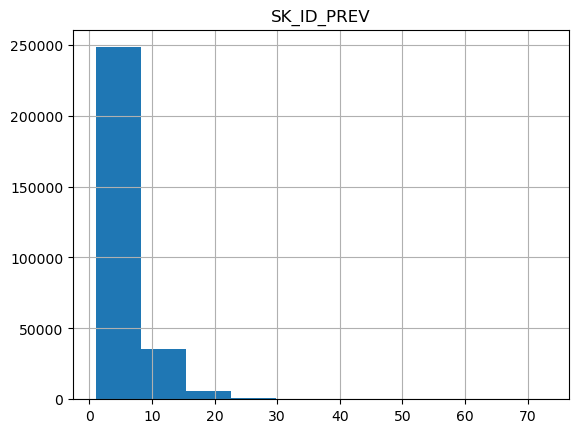

In [61]:
# Có nhiều KH có 1-nhiều khoản vay trước đó
df_agg04 = previous_app.groupby("SK_ID_CURR").agg({"SK_ID_PREV": "count"})
display(df_agg04.describe())
df_agg04.hist()
plt.show()

# Save Feature

In [62]:
df_feat = df_agg01.join(df_agg02).join(
    df_agg03).join(df_agg04)
df_feat.shape

(291057, 242)

In [63]:
%%time
fname = "prev_app"
fname = os.path.join("features", "{}.pkl.bz2".format(fname))
df_feat.to_pickle(fname, compression="bz2")
print("Store features completed!")

Store features completed!
Wall time: 28 s


In [64]:
import pickle
import bz2

filename = "features/prev_app.pkl.bz2"
with bz2.open(filename, 'rb') as f:
    df_out = pickle.load(f)

print(df_out.shape)
df_out

(291057, 242)


,NAME_PRODUCT_TYPE_walk_in_sum,NAME_PRODUCT_TYPE_walk_in_mean,NAME_PRODUCT_TYPE_walk_in_max,NAME_CONTRACT_TYPE_Revolving_loans_sum,NAME_CONTRACT_TYPE_Revolving_loans_mean,PRODUCT_COMBINATION_Card_Street_sum,NAME_CONTRACT_TYPE_Consumer_loans_mean,PRODUCT_COMBINATION_Card_Street_mean,NAME_CONTRACT_TYPE_Revolving_loans_max,PRODUCT_COMBINATION_Card_Street_max,PRODUCT_COMBINATION_Cash_X_Sell__low_mean,NAME_CONTRACT_TYPE_Consumer_loans_sum,PRODUCT_COMBINATION_Cash_X_Sell__low_max,PRODUCT_COMBINATION_POS_industry_with_interest_mean,PRODUCT_COMBINATION_Cash_X_Sell__low_sum,PRODUCT_COMBINATION_POS_industry_with_interest_sum,PRODUCT_COMBINATION_POS_industry_with_interest_max,NAME_TYPE_SUITE_Unaccompanied_mean,NAME_TYPE_SUITE_Family_mean,NAME_PRODUCT_TYPE_XNA_mean,PRODUCT_COMBINATION_Cash_X_Sell__high_sum,PRODUCT_COMBINATION_Cash_Street__high_sum,PRODUCT_COMBINATION_Cash_Street__high_mean,PRODUCT_COMBINATION_Cash_Street__high_max,PRODUCT_COMBINATION_Cash_X_Sell__high_mean,PRODUCT_COMBINATION_Cash_X_Sell__high_max,NAME_TYPE_SUITE_Family_max,NAME_TYPE_SUITE_Family_sum,PRODUCT_COMBINATION_POS_household_without_interest_mean,PRODUCT_COMBINATION_POS_household_without_interest_sum,NAME_TYPE_SUITE_Unaccompanied_sum,PRODUCT_COMBINATION_POS_household_without_interest_max,PRODUCT_COMBINATION_POS_mobile_with_interest_mean,PRODUCT_COMBINATION_Cash_sum,NAME_CONTRACT_TYPE_Cash_loans_sum,PRODUCT_COMBINATION_POS_mobile_with_interest_sum,NAME_PRODUCT_TYPE_x_sell_mean,PRODUCT_COMBINATION_POS_mobile_with_interest_max,PRODUCT_COMBINATION_Cash_mean,PRODUCT_COMBINATION_POS_household_with_interest_sum,PRODUCT_COMBINATION_POS_household_with_interest_mean,NAME_CONTRACT_TYPE_Cash_loans_mean,PRODUCT_COMBINATION_Cash_max,PRODUCT_COMBINATION_Cash_Street__middle_sum,PRODUCT_COMBINATION_Cash_Street__middle_max,PRODUCT_COMBINATION_Cash_Street__middle_mean,PRODUCT_COMBINATION_Cash_X_Sell__middle_mean,PRODUCT_COMBINATION_POS_household_with_interest_max,PRODUCT_COMBINATION_Card_X_Sell_sum,PRODUCT_COMBINATION_Card_X_Sell_max,PRODUCT_COMBINATION_Card_X_Sell_mean,PRODUCT_COMBINATION_Cash_X_Sell__middle_sum,PRODUCT_COMBINATION_Cash_X_Sell__middle_max,NAME_TYPE_SUITE_Children_mean,NAME_CONTRACT_TYPE_Cash_loans_max,NAME_TYPE_SUITE_Children_max,NAME_TYPE_SUITE_Children_sum,FLAG_LAST_APPL_PER_CONTRACT_Y_sum,WEEKDAY_APPR_PROCESS_START_SATURDAY_mean,WEEKDAY_APPR_PROCESS_START_MONDAY_sum,WEEKDAY_APPR_PROCESS_START_SUNDAY_mean,NAME_PRODUCT_TYPE_x_sell_max,NAME_PRODUCT_TYPE_x_sell_sum,PRODUCT_COMBINATION_POS_industry_without_interest_mean,PRODUCT_COMBINATION_POS_industry_without_interest_max,PRODUCT_COMBINATION_POS_industry_without_interest_sum,NAME_CONTRACT_TYPE_Consumer_loans_max,WEEKDAY_APPR_PROCESS_START_SUNDAY_max,WEEKDAY_APPR_PROCESS_START_SATURDAY_max,WEEKDAY_APPR_PROCESS_START_THURSDAY_sum,WEEKDAY_APPR_PROCESS_START_SUNDAY_sum,WEEKDAY_APPR_PROCESS_START_MONDAY_max,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_sum,WEEKDAY_APPR_PROCESS_START_FRIDAY_sum,WEEKDAY_APPR_PROCESS_START_MONDAY_mean,PRODUCT_COMBINATION_Cash_Street__low_sum,PRODUCT_COMBINATION_Cash_Street__low_max,PRODUCT_COMBINATION_Cash_Street__low_mean,NAME_PRODUCT_TYPE_XNA_sum,NAME_TYPE_SUITE_Unaccompanied_max,WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,WEEKDAY_APPR_PROCESS_START_TUESDAY_sum,"NAME_TYPE_SUITE_Spouse,_partner_mean","NAME_TYPE_SUITE_Spouse,_partner_max",WEEKDAY_APPR_PROCESS_START_THURSDAY_mean,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_max,"NAME_TYPE_SUITE_Spouse,_partner_sum",WEEKDAY_APPR_PROCESS_START_FRIDAY_max,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_mean,WEEKDAY_APPR_PROCESS_START_THURSDAY_max,WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,NAME_PRODUCT_TYPE_XNA_max,PRODUCT_COMBINATION_POS_other_with_interest_mean,PRODUCT_COMBINATION_POS_other_with_interest_max,PRODUCT_COMBINATION_POS_other_with_interest_sum,FLAG_LAST_APPL_PER_CONTRACT_N_sum,FLAG_LAST_APPL_PER_CONTRACT_Y_mean,FLAG_LAST_APPL_PER_CONTRACT_N_mean,FLAG_LAST_APPL_PER_CONTRACT_N_max,PRODUCT_COMBINATION_POS_mobile_without_interest_mean,PRODUCT_COMBINATION_POS_mobile_with